## Test: Determine Lambda empirically

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Statistics
from sklearn.linear_model import LinearRegression
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        False,
    'sav_css':        False, # Save cases during fitting
    'sav_inf':        False, # Save cases inferences
}

PTHS = {
    'dsg_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
    'sav_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_TIME_EVOLUTION/08_PAPER/'
}

### 1) FUNCTIONS

In [3]:
rs = np.linspace(10, 900000, 90000)
dr = 10 # meters

# rs = np.linspace(10000, 900000, 90)
# dr = 10000 # meters

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / r) * np.gradient(r * v, dr)

def v_k10(v0, t, alpha=1., lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                             # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(alpha * t)})    # Inner-core: v0 interpolated on r * e^t
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + alpha * t)) # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})                       # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * alpha * t)              # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})                       # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(alpha * t) + v0.rad * (np.exp(2 * alpha * t) - 1) / (2 * alpha)                                     # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * alpha * v0.rad) + np.log(v0.rad) / v0.rad + alpha * t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + alpha * t / v0.rad                                                                      # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((alpha - lbda) * t) + alpha * v0.rad * (1 - np.exp((2 * alpha - lbda) * t)) / (lbda - 2 * alpha)                                # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + alpha * (lbda * v0.rad ** 2 - 2 * alpha * v0.rad ** (lbda / alpha)) / (lbda * v0.rad * (lbda - 2 * alpha)) - alpha * np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + alpha * (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-alpha * t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def compute_RV_plus(r, V, fcor, n=5):
    # Compute R+
    rm       = r[np.nanargmax(V)]
    out      = r > rm          # To find outer-core
    r        = r[out]
    V        = V[out]
    vrt      = vorticity(r, V) # Relative vorticity
    vrt_plan = fcor            # Planetary vorticity

    try: 
        R_plus = r[abs(vrt - n * vrt_plan) < 1e-6][0] # R+
        V_plus = V[r >= R_plus][0]
    except IndexError:
        print('Error: R+ non defined.')
        R_plus = V_plus = np.nan
    
    return R_plus, V_plus

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

def BL_height(r, a):
    '''a is the slope of the BL height'''
    return a * r

# def BL_height(r, a, Rp):
#     return a * (1 - np.exp(-(r / Rp) ** 0.1))

# def BL_height(r, a, Rp):
#     return (2 * a / np.pi) * np.arctan((r / Rp))

def u(r, alpha, fcor_ini, Rp_ini):
    u    = np.zeros_like(r) 
    u_in = -alpha * fcor_ini * r
    u_ou = -alpha * fcor_ini * (Rp_ini ** 2) / r
    u[r <= Rp_ini] = u_in[r <= Rp_ini]
    u[r >= Rp_ini] = u_ou[r >= Rp_ini]
    return u # dimensional

def propagate(r, a, alpha, V_ini, fcor_ini, dt=1, fitting_mode=False, Cd_plus=2.5e-3):
    # Compute R+, V+
    R_plus, V_plus = compute_RV_plus(r, V_ini, fcor_ini, PRMS['n'])
    # print('R+ = {:.0f}, V+ = {:.1f}'.format(R_plus, V_plus))
    
    # Compute BL height 
    h              = BL_height(r, a / 1000)
    # h                = a * np.ones_like(r)
    # h              = BL_height(r, a, R_plus)
    
    # Compute lambda
    # M_abs          = r * V_ini + 0.5 * fcor_ini * (r ** 2)
    M_rel          = r * V_ini
    lbda           = float(Cd_plus * R_plus * (V_plus ** 2)) / (h * M_rel) # dimensional
    # lbda           = float(Cd_plus * R_plus * (V_plus ** 2)) / (h * M_rel) - (fcor_ini * r * u(r, alpha, fcor_ini, R_plus) / M_rel) # dimensional
    lbda           = lbda / fcor_ini                                       # non-dimensional
    
    # plt.plot(r / 1000, 1e6 / r ** 2, c='k')
    # plt.plot(r / 1000, lbda);plt.yscale('log');plt.xlim(0, 300);plt.show()
    
    # Normalize
    V_nrm = xr.DataArray(
        data=V_ini / (fcor_ini * R_plus),
        coords={'rad': r / R_plus}
    )
    
    # Apply KK10
    V = v_k10(V_nrm, dt, alpha, lbda=lbda) * fcor_ini * R_plus             # dimensional
    
    # # Option 1: Fit the whole curve
    # # In fitting mode, match values of nan with values of initial profile so that it doesn't count
    # if fitting_mode:
    #     V[np.isnan(V)] = V_ini[np.isnan(V)]
    
    # Option 2: Fit Vmax
    if fitting_mode:
        V = np.nanmax(V)

    return V

### 2) SAR DATA

In [4]:
dsg  = xr.open_dataset(PTHS['dsg_pth'])

### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
dsg = dsg.where(dsg.Vmax_1D > 25, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))

# Manually add Goni because its R17 is nan (I don't know why)
goni      = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/Goni_sample.nc')
dsg       = xr.concat((dsg, goni), dim='time')

# Select IDs where there are at least 2 SAR images
ids, cts  = np.unique(dsg.storm_id, return_counts=True)
valid_ids = ids[cts > 1]
valid_cts = cts[cts > 1]

print('Mean latitude = {:.1f}°'.format(abs(dsg.lat_center).mean()))
print('Mean Coriolis = {:.1e}'.format(float(coriolis(abs(dsg.lat_center).mean()))))

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Nb of storms: 161
SAR Mean Rmax = 31 km
SAR Mean R64  = 57 km
Mean latitude = 18.9°
Mean Coriolis = 4.7e-05


### 3) Determine lambda

In [115]:
# Parameters
time_thresh  = 20

# id = 3, 10

# Iterate
for tc_id in tqdm(valid_ids[:10]):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if (delta_h <= time_thresh) & (delta_h > 1):
                V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
                Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
                fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
                fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
                # dt
                tau      = ((1 / fcor_ini) / 3600)
                dt       = delta_h / tau
                
                # Alpha
                alpha = 1

  0%|          | 0/10 [00:00<?, ?it/s]

In [116]:
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar

def propagate(r, lbda, V_ini, fcor_ini, dt=1, alpha=1, Cd_plus=2.5e-3):
    # Compute R+, V+
    R_plus, V_plus = compute_RV_plus(r, V_ini, fcor_ini, PRMS['n'])
    
    # Normalize
    V_nrm = xr.DataArray(
        data=V_ini / (fcor_ini * R_plus),
        coords={'rad': r / R_plus}
    )
    # lbda = lbda / fcor_ini                                       # non-dimensional
    
    # Apply KK10
    V = v_k10(V_nrm, dt, alpha, lbda=lbda) * fcor_ini * R_plus # dimensional

    return V

def loss(lbda, V_ini, V_fin):
    V_mod = propagate(rs, lbda * V_ini, V_fin, fcor_ini, dt=dt)
    return np.sqrt(np.nanmean((V_fin - V_mod) ** 2)) 

# # Initialize
# lbda0    = fcor_ini
# # Optimize
# lbda_opt = minimize(loss, lbda0, args=(Vh_ini, Vh_fin))

# # Plot
# V     = propagate(rs, lbda_opt.x * Vh_ini, Vh_ini, fcor_ini, dt=dt)
# plt.plot(rs / 1000, Vh_ini, c='k', label='SAR ini', linewidth=3)
# plt.plot(rs / 1000, Vh_fin, c='orangered', label='SAR fin', linewidth=3)
# plt.plot(rs / 1000, V, linestyle='dashed', c='orangered', label='MODEL')
# plt.xlim(0, 300)
# plt.grid();plt.legend()

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


0.10395169853145735
7.699963694300125 8.053606945970202


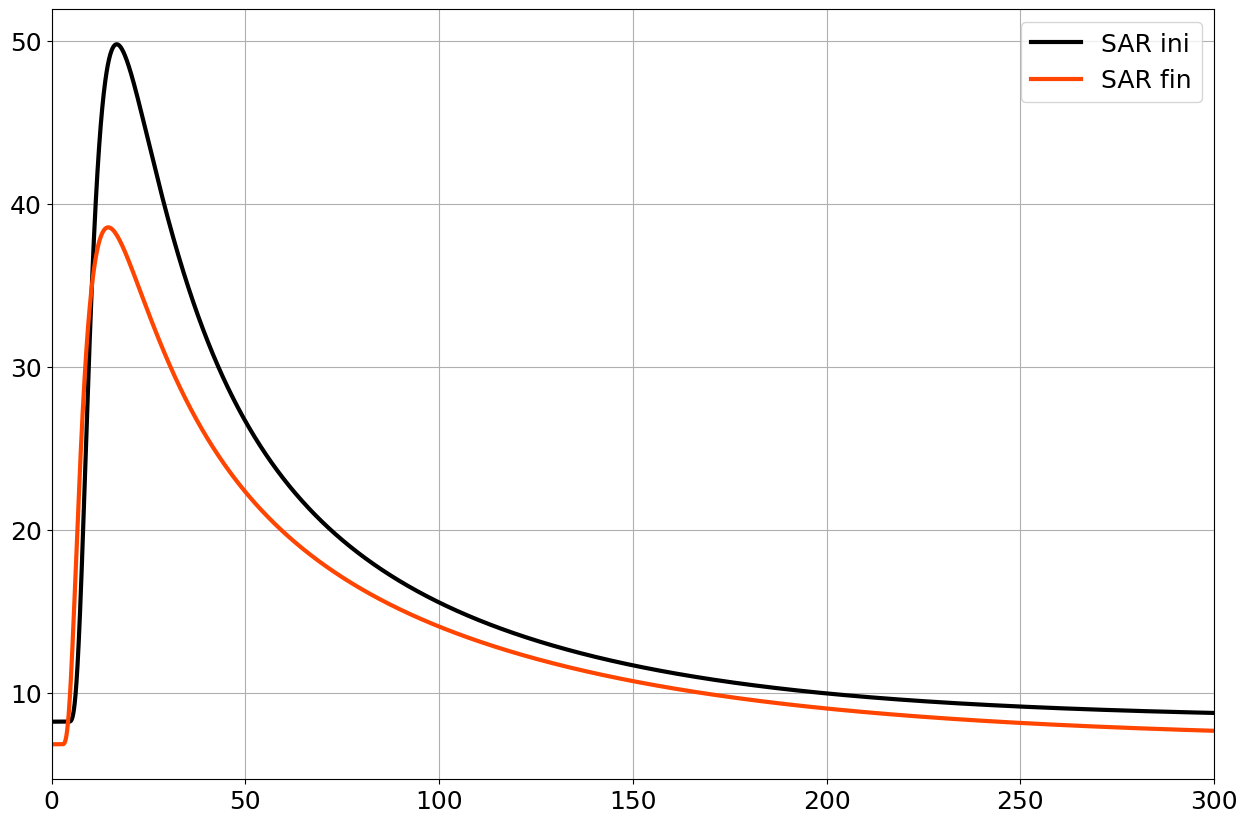

In [117]:
def local_loss(lbda, i, V_ini, V_fin):
    V_mod = propagate(rs, lbda, V_ini, fcor_ini, dt=dt)
    # print(lbda, V_mod[i])
    return np.sqrt((V_fin[i] - V_mod[i]) ** 2)

i     = 30000

lbda0 = 0.7

opt   = minimize_scalar(local_loss, args=(i, Vh_ini, Vh_fin), tol=1e-5)
# , bounds=([0.5, 1.5], )
print(opt.x)

# Plot
# V     = propagate(rs, opt.x, Vh_ini, fcor_ini, dt=dt)
print(Vh_fin[i], V[i])
plt.plot(rs / 1000, Vh_ini, c='k', label='SAR ini', linewidth=3)
plt.plot(rs / 1000, Vh_fin, c='orangered', label='SAR fin', linewidth=3)
# plt.plot(rs / 1000, V, linestyle='dashed', c='orangered', label='MODEL')
plt.xlim(0, 300)
plt.grid();plt.legend()

In [118]:
lbda0 = 0.7
LBDAS = []
IS    = []

for i in tqdm(rs[999::1000][:10]):
    i     = int(i / 10)
    opt   = minimize_scalar(local_loss, args=(i, Vh_ini, Vh_fin), tol=1e-5)

    # Plot
    V     = propagate(rs, opt.x, Vh_ini, fcor_ini, dt=dt)
    print(Vh_fin[i], V[i])
    
    # Append
    LBDAS.append(opt.x)
    IS.append(i)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


34.09466204441958 34.09469448386415


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


36.42878594491928 36.42879352385044


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


30.362156138703575 30.36218454298573


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


25.697208379860918 25.69724783758847


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


22.338541583895125 22.338572457578103


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


19.842185164736733 19.842160375401594


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


17.91604845601052 17.91606172521599


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


16.382036506146 16.38204578187336


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


15.129194606010515 15.129188026005467


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


14.085814548339451 14.085832792967203


(-1.0, 100.0)

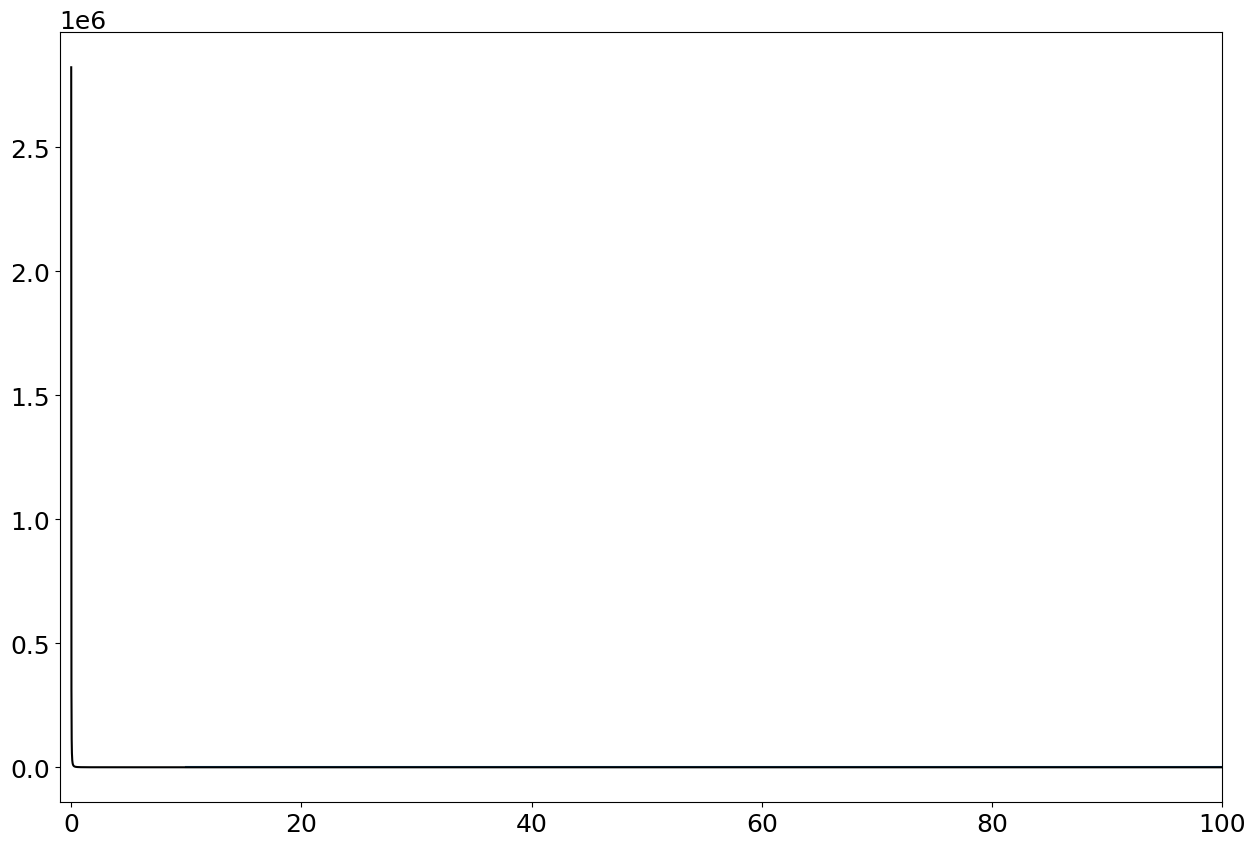

In [ ]:
plt.plot(rs[IS] / 1000, LBDAS)
plt.plot(rs / 1000, rs[np.nanargmax(Vh_ini)] ** 2 / (rs ** 2), c='k')
plt.xlim(-1, 100)
# plt.ylim(0, 2)

In [43]:
# def local_loss(lbda, i, V_ini, V_fin):
#     V_mod = propagate(rs, lbda, V_ini, fcor_ini, dt=dt)
#     print(lbda, V_mod[i])
#     return np.sqrt((V_fin[i] - V_mod[i]) ** 2)


# i     = 10000

# lbda0 = 0.7

# opt   = minimize(local_loss, lbda0, args=(i, Vh_ini, Vh_fin), tol=1e-5)
# # , bounds=([0.5, 1.5], )
# print(opt.x)

# # Plot
# V     = propagate(rs, opt.x, Vh_ini, fcor_ini, dt=dt)
# print(Vh_fin[i], V[i])
# plt.plot(rs / 1000, Vh_ini, c='k', label='SAR ini', linewidth=3)
# plt.plot(rs / 1000, Vh_fin, c='orangered', label='SAR fin', linewidth=3)
# plt.plot(rs / 1000, V, linestyle='dashed', c='orangered', label='MODEL')
# plt.xlim(0, 300)
# plt.grid();plt.legend()

### 3) REGRESSION

In [8]:
# COLORMAP
colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered')] # first color is black, last is red
cm     = LinearSegmentedColormap.from_list("Custom", colors, N=20)
l      = 5 # nb of model steps to display
clrs   = cm(np.linspace(0, 1, l + 1))

# Parameters
time_thresh  = 20

# Initialization
IDXS_INI     = []
IDXS_FIN     = []
TC_IDS       = []
DELTA_HS     = []
VMXS_INI     = []
RMXS_INI     = []
FCRS_INI     = []
FCRS_FIN     = []
VMXS_FIN     = []
RMXS_FIN     = []
AS           = []
RPLS_INI     = []
RPLS_FIN     = []
RPLS_MOD     = []
VPLS_INI     = []
VPLS_FIN     = []
HPLS         = []
HPLS_FIN     = []
DMPLS        = []
DMPLS_FIN    = []
BHOLS        = []
# Errors
RMSES        = []
RMSES_PRS    = []
REL_ERRS     = []
REL_ERRS_PRS = []
r_ref        = np.linspace(0, 10, 1001)

# Iterate
for tc_id in tqdm(valid_ids):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if (delta_h <= time_thresh) & (delta_h > 1):
                V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
                Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
                fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
                fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
                # dt
                tau      = ((1 / fcor_ini) / 3600)
                dt       = delta_h / tau
                
                # Alpha, h is constant
                # alpha = 0.1
                # alpha = 0.3
                alpha = 0.5
                # alpha = 1
                # alpha = 10
                
                # Fitting
                a_fit, pcov = curve_fit(
                    lambda r, a: propagate(r, a, alpha, Vh_ini, fcor_ini, dt, fitting_mode=True),
                    rs,
                    # Vh_fin,          # Option 1: Fit the whole curve
                    np.nanmax(V_fin),  # Option 2: Fit Vmax
                    p0=1000,
                    bounds=[10, 10000],
                    # p0=100,
                    # bounds=[10, 1000],
                )
                
                # Model
                V = propagate(rs, a_fit, alpha, Vh_ini, fcor_ini, dt=dt)
            
                print(tc_id)
                print('delta_h = {:.1f}hr'.format(delta_h))
                print('a = {:.2f}'.format(float(a_fit)))
                
                # Compute R+ metrics
                Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini,    float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                Rp_fin, Vp_fin   = compute_RV_plus(rs, Vh_fin,    float(abs(coriolis(ds_fin.lat_center))), PRMS['n'])
                V                = propagate(rs, a_fit, alpha, Vh_ini, fcor_ini, dt)
                Rp_mod, Vp_mod   = compute_RV_plus(rs, V,         float(abs(coriolis(ds_fin.lat_center))), PRMS['n'])
                # Hp               = np.nan
                Hp               = BL_height(Rp_ini, a_fit / 1000) # see my function propagate() (factor 1000 to suit the curve_fit() bounds)
                # Hp               = BL_height(Rp_ini, a_fit, Rp_ini)
                dMp              = np.gradient(rs * Vh_ini + 0.5 * fcor_ini * (rs ** 2), dr)[rs >= Rp_ini][0] # dM/dr at R+
                dMp_fin          = np.gradient(rs * Vh_fin + 0.5 * float(abs(coriolis(ds_fin.lat_center))) * (rs ** 2), dr)[rs >= Rp_fin][0] # dM/dr at R+
                
                # Compute RMSE
                rmse        = np.sqrt(np.nanmean((V - Vh_fin) ** 2))      # Model
                rmse_prs    = np.sqrt(np.nanmean((Vh_ini - Vh_fin) ** 2)) # Persistence    
                # Option 1: Compute relative to Holland final profile
                rel_err          = (V - Vh_fin) / Vh_fin
                rmx              = rs[np.nanargmax(Vh_fin)]
                r_star           = rs / rmx
                rel_err_star     = np.interp(r_ref, r_star, rel_err)
                rel_err_prs      = (Vh_ini - Vh_fin) / Vh_fin             # Persistence
                rel_err_prs_star = np.interp(r_ref, r_star, rel_err_prs)  # Persistence
                    
                # Appends
                IDXS_INI.append(idx_ini), IDXS_FIN.append(idx_fin), TC_IDS.append(tc_id), DELTA_HS.append(delta_h), AS.append(float(a_fit))  
                VMXS_INI.append(np.nanmax(V_ini)), RMXS_INI.append(rs[np.nanargmax(V_ini)]), FCRS_INI.append(fcor_ini),
                VMXS_FIN.append(np.nanmax(V_fin)), RMXS_FIN.append(rs[np.nanargmax(V_fin)]), FCRS_FIN.append(fcor_fin),
                RPLS_INI.append(Rp_ini), RPLS_FIN.append(Rp_fin), RPLS_MOD.append(Rp_mod), VPLS_INI.append(Vp_ini), VPLS_FIN.append(Vp_fin),
                HPLS.append(float(Hp)), DMPLS.append(float(dMp)), DMPLS_FIN.append(float(dMp_fin)), BHOLS.append(float(ds_ini.B_hol))
                RMSES_PRS.append(rmse_prs), RMSES.append(rmse)
                REL_ERRS.append(rel_err_star), REL_ERRS_PRS.append(rel_err_prs_star)

                # Plot
                if PRMS['sav_css']:
                    plt.title('{}, idx_ini = {}, idx_fin = {} \n delta_h = {:.1f} hrs, a = {:.2f}'.format(tc_id, idx_ini, idx_fin, delta_h, float(a_fit)), weight='bold')
                    # plt.suptitle('Note that alpha = 0.3')
                    # SAR                  
                    plt.plot(rs / 1000, V_ini, c='k',         linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(ds_ini.time, unit='m')[5:]))
                    plt.plot(rs / 1000, V_fin, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(ds_fin.time, unit='m')[5:]))
                    # # Holland
                    plt.plot(rs / 1000, Vh_ini, c='k', label='Holland initial')
                    # plt.plot(rs / 1000, Vh_fin, linewidth=3, linestyle='dotted', c='orangered', label='Holland final')
                    # # Model
                    # for k in range(1, l + 1):
                    #     V = propagate(rs, a_fit, Vh_ini, fcor_ini, dt=k * dt / l)
                    #     plt.plot(rs / 1000, V, linestyle='dashed', c=clrs[k], label='MODEL, step {}'.format(k))
                    plt.plot(rs / 1000, V, linestyle='dashed', c='orangered', label='MODEL')
                    # V = propagate(rs, a_fit, Vh_ini, fcor_ini, dt=dt)
                    # plt.plot(rs / 1000, V, c='orangered', linestyle='dashed', label='MODEL')
                    # V2 = propagate(rs, a_fit, Vh_ini, fcor_ini, dt=dt/2)
                    # plt.plot(rs / 1000, V2, c='orange', linestyle='dashed', label='MODEL mid-time')
                    # Grids
                    plt.grid();plt.legend(loc='upper right')
                    plt.xlim(0, 300)
                    plt.xlabel('r (km)')
                    plt.ylabel('Wind speed (m/s)')

                    # Save
                    plt.savefig(PTHS['sav_dir'] + 'cases/{}_ini{}_fin{}'.format(tc_id, idx_ini, idx_fin));plt.clf()
                                   
dsf = xr.Dataset(
    data_vars={
        'tc_id':       ('pair', np.array(TC_IDS).astype(str)),
        'idx_ini':     ('pair', IDXS_INI),
        'idx_fin':     ('pair', IDXS_FIN),
        'delta_h':     ('pair', DELTA_HS),
        'a':           ('pair', AS),
        'fcor_ini':    ('pair', FCRS_INI),
        'fcor_fin':    ('pair', FCRS_FIN),
        'vmx_ini':     ('pair', VMXS_INI),
        'vmx_fin':     ('pair', VMXS_FIN),
        'rmx_ini':     ('pair', RMXS_INI),
        'rmx_fin':     ('pair', RMXS_FIN),
        'Rp_ini':      ('pair', RPLS_INI),
        'Rp_fin':      ('pair', RPLS_FIN),
        'Rp_mod':      ('pair', RPLS_MOD),
        'Vp_ini':      ('pair', VPLS_INI),
        'Vp_fin':      ('pair', VPLS_FIN),
        'Hp':          ('pair', HPLS),
        'dMp':         ('pair', DMPLS),
        'dMp_fin':     ('pair', DMPLS_FIN),
        'B_hol':       ('pair', BHOLS),
        'rmse':        ('pair', RMSES),
        'rmse_prs':    ('pair', RMSES_PRS),
        'rel_err':     (('pair', 'r*'), REL_ERRS),
        'rel_err_prs': (('pair', 'r*'), REL_ERRS_PRS),
    }
)

  0%|          | 0/39 [00:00<?, ?it/s]

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


al122021
delta_h = 11.8hr
a = 348.99


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


al122021
delta_h = 12.3hr
a = 138.43



KeyboardInterrupt

